# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.layers.rnn import SimpleRNN, LSTM, GRU
from src.activations import Sigmoid, Tanh, Linear
from src.losses import MSE
from src.models import Sequential

# Load dataset

In [2]:
from ucimlrepo import fetch_ucirepo 
  
steel_industry_energy_consumption = fetch_ucirepo(id=851) 
data = steel_industry_energy_consumption.data.features 
print(steel_industry_energy_consumption.metadata) 
print(steel_industry_energy_consumption.variables)

{'uci_id': 851, 'name': 'Steel Industry Energy Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/851/steel+industry+energy+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/851/data.csv', 'abstract': 'The data is collected from a smart small-scale steel industry in South Korea.', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 35040, 'num_features': 9, 'feature_types': ['Real', 'Categorical'], 'demographics': [], 'target_col': ['Load_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2021, 'last_updated': 'Mon Aug 14 2023', 'dataset_doi': '10.24432/C52G8C', 'creators': ['Sathishkumar V E', 'Changsun Shin', 'Yongyun Cho'], 'intro_paper': {'ID': 262, 'type': 'NATIVE', 'title': 'Efficient energy consumption prediction model for a data analytic-enabled industry building in a smart city', 'authors': 'Sathishkumar V E, Changsun S

In [3]:
data.head(10)

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week
0,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday
1,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday
2,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday
3,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday
4,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday
5,3.28,3.56,0.0,0.0,67.76,100.0,5400,Weekday,Monday
6,3.60,4.14,0.0,0.0,65.62,100.0,6300,Weekday,Monday
7,3.60,4.28,0.0,0.0,64.37,100.0,7200,Weekday,Monday
8,3.28,3.64,0.0,0.0,66.94,100.0,8100,Weekday,Monday
9,3.78,4.72,0.0,0.0,62.51,100.0,9000,Weekday,Monday


# Preprocessing

In [4]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

categorical = ['WeekStatus', 'Day_of_week', 'NSM', 'CO2(tCO2)']
numerical = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor' ]
target = 'Usage_kWh'

label_encoder = LabelEncoder()
scaler = MinMaxScaler()

df = data.copy()

for col_name in categorical:
    df[col_name] = label_encoder.fit_transform(data[col_name])

df[numerical] = scaler.fit_transform(data[numerical])

In [5]:
df.head(10)

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week
0,0.020168,0.030441,0.0,0,0.7321,1.0,1,0,1
1,0.025449,0.046022,0.0,0,0.6677,1.0,2,0,1
2,0.020613,0.033846,0.0,0,0.7028,1.0,3,0,1
3,0.021059,0.036735,0.0,0,0.6809,1.0,4,0,1
4,0.024303,0.046435,0.0,0,0.6472,1.0,5,0,1
5,0.020868,0.036735,0.0,0,0.6776,1.0,6,0,1
6,0.022904,0.042720,0.0,0,0.6562,1.0,7,0,1
7,0.022904,0.044165,0.0,0,0.6437,1.0,8,0,1
8,0.020868,0.037561,0.0,0,0.6694,1.0,9,0,1
9,0.024049,0.048705,0.0,0,0.6251,1.0,10,0,1


In [6]:
samples = df[target].count()
features = df.shape[1]
batch_size = 32
seq_len = 8
num_batches = samples // (batch_size * seq_len)
train_size = int(0.8 * num_batches)

trimmed_data = df[:num_batches * batch_size * seq_len].to_numpy()
reshaped_data = trimmed_data.reshape(batch_size, -1, features)
batched_data = np.array(np.split(reshaped_data, num_batches, axis=1))
batched_data = batched_data.transpose(0, 2, 1, 3)

X_train = batched_data[:train_size, :, :, 1:]
X_test = batched_data[train_size:, :, :, 1:]

y_train = batched_data[:train_size, :, :, :1]
y_test = batched_data[train_size:, :, :, :1]

print(f'train size: {train_size}, test size {samples-train_size}')

train size: 108, test size 34932


In [7]:
reshaped_data.shape

(32, 1088, 9)

In [8]:
batched_data.shape

(136, 8, 32, 9)

In [9]:
print(f'X_train.shape {X_train.shape}, y_train.shape {y_train.shape}')

X_train.shape (108, 8, 32, 8), y_train.shape (108, 8, 32, 1)


In [10]:
def split_for_rnn(features, labels, seq_len):
    X, y = [], []
    for i in range(len(features) - seq_len):
        X.append(features[i:i + seq_len])  # Окно признаков
        y.append(labels[i:i + seq_len])  # Метка последнего шага
    return np.array(X), np.array(y)

In [11]:
def create_batches(X, y, batch_size):
    num_samples = X.shape[1]
    batches = []

    total_batches = num_samples // batch_size
    if num_samples % batch_size != 0:
        total_batches += 1

    for i in range(total_batches):
        start = i * batch_size
        end = min(start + batch_size, num_samples)

        batch_X = X[:, start:end]
        batch_y = y[:, start:end]

        batches.append((batch_X, batch_y))

    return batches

In [12]:
batches = tuple(zip(X_train, y_train))

In [13]:
len(batches)

108

# Model

In [14]:
mse = MSE()

In [15]:
gru = Sequential(
    GRU(output_size=16),
    GRU(output_size=1)
)
gru.fit(X_train, y_train, batches=batches, loss_function=mse, epochs=40, learning_rate=0.0009)

Epoch 1/40: 100%|██████████| 108/108 [00:00<00:00, 468.46batch/s, Loss=0.0517]


Epoch 1/40 | Loss: 0.094195


Epoch 2/40: 100%|██████████| 108/108 [00:00<00:00, 519.93batch/s, Loss=0.00375]


Epoch 2/40 | Loss: 0.015154


Epoch 3/40: 100%|██████████| 108/108 [00:00<00:00, 515.99batch/s, Loss=0.00291]


Epoch 3/40 | Loss: 0.004122


Epoch 4/40: 100%|██████████| 108/108 [00:00<00:00, 448.53batch/s, Loss=0.00244]


Epoch 4/40 | Loss: 0.003327


Epoch 5/40: 100%|██████████| 108/108 [00:00<00:00, 505.97batch/s, Loss=0.0021] 


Epoch 5/40 | Loss: 0.002840


Epoch 6/40: 100%|██████████| 108/108 [00:00<00:00, 516.75batch/s, Loss=0.00184]


Epoch 6/40 | Loss: 0.002480


Epoch 7/40: 100%|██████████| 108/108 [00:00<00:00, 498.50batch/s, Loss=0.00169]


Epoch 7/40 | Loss: 0.002233


Epoch 8/40: 100%|██████████| 108/108 [00:00<00:00, 522.56batch/s, Loss=0.00158]


Epoch 8/40 | Loss: 0.002082


Epoch 9/40: 100%|██████████| 108/108 [00:00<00:00, 451.20batch/s, Loss=0.00149]


Epoch 9/40 | Loss: 0.001979


Epoch 10/40: 100%|██████████| 108/108 [00:00<00:00, 521.74batch/s, Loss=0.00142] 


Epoch 10/40 | Loss: 0.001899


Epoch 11/40: 100%|██████████| 108/108 [00:00<00:00, 519.78batch/s, Loss=0.00136] 


Epoch 11/40 | Loss: 0.001833


Epoch 12/40: 100%|██████████| 108/108 [00:00<00:00, 517.08batch/s, Loss=0.0013]  


Epoch 12/40 | Loss: 0.001777


Epoch 13/40: 100%|██████████| 108/108 [00:00<00:00, 530.09batch/s, Loss=0.00125] 


Epoch 13/40 | Loss: 0.001728


Epoch 14/40: 100%|██████████| 108/108 [00:00<00:00, 528.69batch/s, Loss=0.00121] 


Epoch 14/40 | Loss: 0.001684


Epoch 15/40: 100%|██████████| 108/108 [00:00<00:00, 495.86batch/s, Loss=0.00117] 


Epoch 15/40 | Loss: 0.001645


Epoch 16/40: 100%|██████████| 108/108 [00:00<00:00, 532.33batch/s, Loss=0.00113] 


Epoch 16/40 | Loss: 0.001608


Epoch 17/40: 100%|██████████| 108/108 [00:00<00:00, 532.85batch/s, Loss=0.00109] 


Epoch 17/40 | Loss: 0.001573


Epoch 18/40: 100%|██████████| 108/108 [00:00<00:00, 534.65batch/s, Loss=0.00106] 


Epoch 18/40 | Loss: 0.001541


Epoch 19/40: 100%|██████████| 108/108 [00:00<00:00, 526.79batch/s, Loss=0.00103] 


Epoch 19/40 | Loss: 0.001512


Epoch 20/40: 100%|██████████| 108/108 [00:00<00:00, 504.56batch/s, Loss=0.000996]


Epoch 20/40 | Loss: 0.001485


Epoch 21/40: 100%|██████████| 108/108 [00:00<00:00, 492.56batch/s, Loss=0.000969]


Epoch 21/40 | Loss: 0.001460


Epoch 22/40: 100%|██████████| 108/108 [00:00<00:00, 524.36batch/s, Loss=0.000942]


Epoch 22/40 | Loss: 0.001437


Epoch 23/40: 100%|██████████| 108/108 [00:00<00:00, 531.62batch/s, Loss=0.000917]


Epoch 23/40 | Loss: 0.001415


Epoch 24/40: 100%|██████████| 108/108 [00:00<00:00, 542.66batch/s, Loss=0.000893]


Epoch 24/40 | Loss: 0.001394


Epoch 25/40: 100%|██████████| 108/108 [00:00<00:00, 548.80batch/s, Loss=0.00087] 


Epoch 25/40 | Loss: 0.001374


Epoch 26/40: 100%|██████████| 108/108 [00:00<00:00, 540.75batch/s, Loss=0.000848]


Epoch 26/40 | Loss: 0.001354


Epoch 27/40: 100%|██████████| 108/108 [00:00<00:00, 497.09batch/s, Loss=0.000827]


Epoch 27/40 | Loss: 0.001336


Epoch 28/40: 100%|██████████| 108/108 [00:00<00:00, 537.09batch/s, Loss=0.000807]


Epoch 28/40 | Loss: 0.001317


Epoch 29/40: 100%|██████████| 108/108 [00:00<00:00, 535.34batch/s, Loss=0.000788]


Epoch 29/40 | Loss: 0.001300


Epoch 30/40: 100%|██████████| 108/108 [00:00<00:00, 532.22batch/s, Loss=0.000769]


Epoch 30/40 | Loss: 0.001282


Epoch 31/40: 100%|██████████| 108/108 [00:00<00:00, 530.22batch/s, Loss=0.000752]


Epoch 31/40 | Loss: 0.001264


Epoch 32/40: 100%|██████████| 108/108 [00:00<00:00, 520.30batch/s, Loss=0.000736]


Epoch 32/40 | Loss: 0.001246


Epoch 33/40: 100%|██████████| 108/108 [00:00<00:00, 489.92batch/s, Loss=0.00072] 


Epoch 33/40 | Loss: 0.001227


Epoch 34/40: 100%|██████████| 108/108 [00:00<00:00, 514.35batch/s, Loss=0.000704]


Epoch 34/40 | Loss: 0.001210


Epoch 35/40: 100%|██████████| 108/108 [00:00<00:00, 512.37batch/s, Loss=0.000687]


Epoch 35/40 | Loss: 0.001192


Epoch 36/40: 100%|██████████| 108/108 [00:00<00:00, 502.43batch/s, Loss=0.00067] 


Epoch 36/40 | Loss: 0.001175


Epoch 37/40: 100%|██████████| 108/108 [00:00<00:00, 518.27batch/s, Loss=0.000654]


Epoch 37/40 | Loss: 0.001158


Epoch 38/40: 100%|██████████| 108/108 [00:00<00:00, 486.14batch/s, Loss=0.000637]


Epoch 38/40 | Loss: 0.001142


Epoch 39/40: 100%|██████████| 108/108 [00:00<00:00, 518.58batch/s, Loss=0.000622]


Epoch 39/40 | Loss: 0.001128


Epoch 40/40: 100%|██████████| 108/108 [00:00<00:00, 511.13batch/s, Loss=0.000606]

Epoch 40/40 | Loss: 0.001114


In [17]:
lstm = Sequential(
    LSTM(output_size=12),
    LSTM(output_size=1)
)
lstm.fit(X_train, y_train, batches=batches, loss_function=mse, epochs=40, learning_rate=0.0009)

Epoch 1/40: 100%|██████████| 108/108 [00:00<00:00, 446.07batch/s, Loss=0.0124]


Epoch 1/40 | Loss: 0.084280


Epoch 2/40: 100%|██████████| 108/108 [00:00<00:00, 422.17batch/s, Loss=0.00477]


Epoch 2/40 | Loss: 0.008814


Epoch 3/40: 100%|██████████| 108/108 [00:00<00:00, 435.42batch/s, Loss=0.00395]


Epoch 3/40 | Loss: 0.005937


Epoch 4/40: 100%|██████████| 108/108 [00:00<00:00, 407.44batch/s, Loss=0.00356]


Epoch 4/40 | Loss: 0.004916


Epoch 5/40: 100%|██████████| 108/108 [00:00<00:00, 443.06batch/s, Loss=0.00327]


Epoch 5/40 | Loss: 0.004253


Epoch 6/40: 100%|██████████| 108/108 [00:00<00:00, 445.74batch/s, Loss=0.00299]


Epoch 6/40 | Loss: 0.003747


Epoch 7/40: 100%|██████████| 108/108 [00:00<00:00, 442.06batch/s, Loss=0.0027] 


Epoch 7/40 | Loss: 0.003335


Epoch 8/40: 100%|██████████| 108/108 [00:00<00:00, 447.47batch/s, Loss=0.00245]


Epoch 8/40 | Loss: 0.002993


Epoch 9/40: 100%|██████████| 108/108 [00:00<00:00, 430.10batch/s, Loss=0.00224]


Epoch 9/40 | Loss: 0.002710


Epoch 10/40: 100%|██████████| 108/108 [00:00<00:00, 454.85batch/s, Loss=0.00207]


Epoch 10/40 | Loss: 0.002477


Epoch 11/40: 100%|██████████| 108/108 [00:00<00:00, 440.59batch/s, Loss=0.00194]


Epoch 11/40 | Loss: 0.002293


Epoch 12/40: 100%|██████████| 108/108 [00:00<00:00, 456.88batch/s, Loss=0.00183]


Epoch 12/40 | Loss: 0.002151


Epoch 13/40: 100%|██████████| 108/108 [00:00<00:00, 445.24batch/s, Loss=0.00174]


Epoch 13/40 | Loss: 0.002038


Epoch 14/40: 100%|██████████| 108/108 [00:00<00:00, 407.51batch/s, Loss=0.00167] 


Epoch 14/40 | Loss: 0.001950


Epoch 15/40: 100%|██████████| 108/108 [00:00<00:00, 456.91batch/s, Loss=0.00161] 


Epoch 15/40 | Loss: 0.001882


Epoch 16/40: 100%|██████████| 108/108 [00:00<00:00, 455.69batch/s, Loss=0.00156] 


Epoch 16/40 | Loss: 0.001825


Epoch 17/40: 100%|██████████| 108/108 [00:00<00:00, 432.22batch/s, Loss=0.00152] 


Epoch 17/40 | Loss: 0.001777


Epoch 18/40: 100%|██████████| 108/108 [00:00<00:00, 410.50batch/s, Loss=0.00148] 


Epoch 18/40 | Loss: 0.001735


Epoch 19/40: 100%|██████████| 108/108 [00:00<00:00, 445.47batch/s, Loss=0.00145] 


Epoch 19/40 | Loss: 0.001698


Epoch 20/40: 100%|██████████| 108/108 [00:00<00:00, 449.36batch/s, Loss=0.00142] 


Epoch 20/40 | Loss: 0.001664


Epoch 21/40: 100%|██████████| 108/108 [00:00<00:00, 451.16batch/s, Loss=0.00139] 


Epoch 21/40 | Loss: 0.001633


Epoch 22/40: 100%|██████████| 108/108 [00:00<00:00, 439.22batch/s, Loss=0.00136] 


Epoch 22/40 | Loss: 0.001605


Epoch 23/40: 100%|██████████| 108/108 [00:00<00:00, 432.19batch/s, Loss=0.00134] 


Epoch 23/40 | Loss: 0.001578


Epoch 24/40: 100%|██████████| 108/108 [00:00<00:00, 426.70batch/s, Loss=0.00132] 


Epoch 24/40 | Loss: 0.001554


Epoch 25/40: 100%|██████████| 108/108 [00:00<00:00, 442.05batch/s, Loss=0.0013]  


Epoch 25/40 | Loss: 0.001531


Epoch 26/40: 100%|██████████| 108/108 [00:00<00:00, 455.04batch/s, Loss=0.00128] 


Epoch 26/40 | Loss: 0.001508


Epoch 27/40: 100%|██████████| 108/108 [00:00<00:00, 418.87batch/s, Loss=0.00126] 


Epoch 27/40 | Loss: 0.001487


Epoch 28/40: 100%|██████████| 108/108 [00:00<00:00, 462.08batch/s, Loss=0.00124] 


Epoch 28/40 | Loss: 0.001467


Epoch 29/40: 100%|██████████| 108/108 [00:00<00:00, 452.04batch/s, Loss=0.00122] 


Epoch 29/40 | Loss: 0.001447


Epoch 30/40: 100%|██████████| 108/108 [00:00<00:00, 454.10batch/s, Loss=0.0012]  


Epoch 30/40 | Loss: 0.001427


Epoch 31/40: 100%|██████████| 108/108 [00:00<00:00, 440.68batch/s, Loss=0.00118] 


Epoch 31/40 | Loss: 0.001407


Epoch 32/40: 100%|██████████| 108/108 [00:00<00:00, 427.49batch/s, Loss=0.00115] 


Epoch 32/40 | Loss: 0.001387


Epoch 33/40: 100%|██████████| 108/108 [00:00<00:00, 445.17batch/s, Loss=0.00112] 


Epoch 33/40 | Loss: 0.001368


Epoch 34/40: 100%|██████████| 108/108 [00:00<00:00, 465.44batch/s, Loss=0.00109] 


Epoch 34/40 | Loss: 0.001348


Epoch 35/40: 100%|██████████| 108/108 [00:00<00:00, 456.45batch/s, Loss=0.00105] 


Epoch 35/40 | Loss: 0.001329


Epoch 36/40: 100%|██████████| 108/108 [00:00<00:00, 458.50batch/s, Loss=0.00102] 


Epoch 36/40 | Loss: 0.001309


Epoch 37/40: 100%|██████████| 108/108 [00:00<00:00, 432.76batch/s, Loss=0.000995]


Epoch 37/40 | Loss: 0.001291


Epoch 38/40: 100%|██████████| 108/108 [00:00<00:00, 463.49batch/s, Loss=0.000973]


Epoch 38/40 | Loss: 0.001274


Epoch 39/40: 100%|██████████| 108/108 [00:00<00:00, 440.90batch/s, Loss=0.000955]


Epoch 39/40 | Loss: 0.001259


Epoch 40/40: 100%|██████████| 108/108 [00:00<00:00, 431.58batch/s, Loss=0.000939]

Epoch 40/40 | Loss: 0.001244


In [19]:
rnn = Sequential( 
    SimpleRNN(output_size=16, activation=Tanh()), 
    SimpleRNN(output_size=1, activation=Tanh(), activation_out=Sigmoid())
)
rnn.fit(X_train, y_train, batches=batches, loss_function=mse, epochs=80, learning_rate=0.001)

Epoch 1/80: 100%|██████████| 108/108 [00:00<00:00, 744.72batch/s, Loss=0.157]


Epoch 1/80 | Loss: 0.142033


Epoch 2/80: 100%|██████████| 108/108 [00:00<00:00, 800.56batch/s, Loss=0.124] 


Epoch 2/80 | Loss: 0.124211


Epoch 3/80: 100%|██████████| 108/108 [00:00<00:00, 735.46batch/s, Loss=0.101] 


Epoch 3/80 | Loss: 0.099449


Epoch 4/80: 100%|██████████| 108/108 [00:00<00:00, 735.49batch/s, Loss=0.0847]


Epoch 4/80 | Loss: 0.082436


Epoch 5/80: 100%|██████████| 108/108 [00:00<00:00, 753.50batch/s, Loss=0.0734]


Epoch 5/80 | Loss: 0.070909


Epoch 6/80: 100%|██████████| 108/108 [00:00<00:00, 748.05batch/s, Loss=0.0656]


Epoch 6/80 | Loss: 0.063099


Epoch 7/80: 100%|██████████| 108/108 [00:00<00:00, 668.74batch/s, Loss=0.06]  


Epoch 7/80 | Loss: 0.057793


Epoch 8/80: 100%|██████████| 108/108 [00:00<00:00, 739.73batch/s, Loss=0.056] 


Epoch 8/80 | Loss: 0.054175


Epoch 9/80: 100%|██████████| 108/108 [00:00<00:00, 745.96batch/s, Loss=0.0531]


Epoch 9/80 | Loss: 0.051698


Epoch 10/80: 100%|██████████| 108/108 [00:00<00:00, 828.50batch/s, Loss=0.051] 


Epoch 10/80 | Loss: 0.049995


Epoch 11/80: 100%|██████████| 108/108 [00:00<00:00, 787.95batch/s, Loss=0.0495]


Epoch 11/80 | Loss: 0.048821


Epoch 12/80: 100%|██████████| 108/108 [00:00<00:00, 765.95batch/s, Loss=0.0483]


Epoch 12/80 | Loss: 0.048011


Epoch 13/80: 100%|██████████| 108/108 [00:00<00:00, 821.13batch/s, Loss=0.0475]


Epoch 13/80 | Loss: 0.047452


Epoch 14/80: 100%|██████████| 108/108 [00:00<00:00, 696.27batch/s, Loss=0.0468]


Epoch 14/80 | Loss: 0.047066


Epoch 15/80: 100%|██████████| 108/108 [00:00<00:00, 771.43batch/s, Loss=0.0463]


Epoch 15/80 | Loss: 0.046802


Epoch 16/80: 100%|██████████| 108/108 [00:00<00:00, 759.23batch/s, Loss=0.0459]


Epoch 16/80 | Loss: 0.046620


Epoch 17/80: 100%|██████████| 108/108 [00:00<00:00, 775.32batch/s, Loss=0.0456]


Epoch 17/80 | Loss: 0.046494


Epoch 18/80: 100%|██████████| 108/108 [00:00<00:00, 756.13batch/s, Loss=0.0454]


Epoch 18/80 | Loss: 0.046382


Epoch 19/80: 100%|██████████| 108/108 [00:00<00:00, 632.41batch/s, Loss=0.0452]


Epoch 19/80 | Loss: 0.046250


Epoch 20/80: 100%|██████████| 108/108 [00:00<00:00, 756.57batch/s, Loss=0.0451]


Epoch 20/80 | Loss: 0.046126


Epoch 21/80: 100%|██████████| 108/108 [00:00<00:00, 758.23batch/s, Loss=0.0449]


Epoch 21/80 | Loss: 0.046086


Epoch 22/80: 100%|██████████| 108/108 [00:00<00:00, 734.70batch/s, Loss=0.0448]


Epoch 22/80 | Loss: 0.046053


Epoch 23/80: 100%|██████████| 108/108 [00:00<00:00, 782.61batch/s, Loss=0.0448]


Epoch 23/80 | Loss: 0.046027


Epoch 24/80: 100%|██████████| 108/108 [00:00<00:00, 771.42batch/s, Loss=0.0447]


Epoch 24/80 | Loss: 0.046015


Epoch 25/80: 100%|██████████| 108/108 [00:00<00:00, 654.48batch/s, Loss=0.0447]


Epoch 25/80 | Loss: 0.046005


Epoch 26/80: 100%|██████████| 108/108 [00:00<00:00, 776.98batch/s, Loss=0.0446]


Epoch 26/80 | Loss: 0.045997


Epoch 27/80: 100%|██████████| 108/108 [00:00<00:00, 755.11batch/s, Loss=0.0446]


Epoch 27/80 | Loss: 0.045988


Epoch 28/80: 100%|██████████| 108/108 [00:00<00:00, 751.31batch/s, Loss=0.0445]


Epoch 28/80 | Loss: 0.045968


Epoch 29/80: 100%|██████████| 108/108 [00:00<00:00, 755.24batch/s, Loss=0.0441]


Epoch 29/80 | Loss: 0.045630


Epoch 30/80: 100%|██████████| 108/108 [00:00<00:00, 729.43batch/s, Loss=0.0192]


Epoch 30/80 | Loss: 0.030970


Epoch 31/80: 100%|██████████| 108/108 [00:00<00:00, 708.09batch/s, Loss=0.0143]


Epoch 31/80 | Loss: 0.014927


Epoch 32/80: 100%|██████████| 108/108 [00:00<00:00, 650.44batch/s, Loss=0.0116] 


Epoch 32/80 | Loss: 0.011805


Epoch 33/80: 100%|██████████| 108/108 [00:00<00:00, 811.89batch/s, Loss=0.00978]


Epoch 33/80 | Loss: 0.009845


Epoch 34/80: 100%|██████████| 108/108 [00:00<00:00, 789.98batch/s, Loss=0.0084] 


Epoch 34/80 | Loss: 0.008459


Epoch 35/80: 100%|██████████| 108/108 [00:00<00:00, 765.97batch/s, Loss=0.00732]


Epoch 35/80 | Loss: 0.007415


Epoch 36/80: 100%|██████████| 108/108 [00:00<00:00, 762.60batch/s, Loss=0.00646]


Epoch 36/80 | Loss: 0.006592


Epoch 37/80: 100%|██████████| 108/108 [00:00<00:00, 760.56batch/s, Loss=0.00575]


Epoch 37/80 | Loss: 0.005923


Epoch 38/80: 100%|██████████| 108/108 [00:00<00:00, 769.95batch/s, Loss=0.00517]


Epoch 38/80 | Loss: 0.005367


Epoch 39/80: 100%|██████████| 108/108 [00:00<00:00, 683.55batch/s, Loss=0.00467]


Epoch 39/80 | Loss: 0.004899


Epoch 40/80: 100%|██████████| 108/108 [00:00<00:00, 788.32batch/s, Loss=0.00425]


Epoch 40/80 | Loss: 0.004497


Epoch 41/80: 100%|██████████| 108/108 [00:00<00:00, 799.70batch/s, Loss=0.00389]


Epoch 41/80 | Loss: 0.004148


Epoch 42/80: 100%|██████████| 108/108 [00:00<00:00, 756.55batch/s, Loss=0.00357]


Epoch 42/80 | Loss: 0.003843


Epoch 43/80: 100%|██████████| 108/108 [00:00<00:00, 776.98batch/s, Loss=0.0033] 


Epoch 43/80 | Loss: 0.003574


Epoch 44/80: 100%|██████████| 108/108 [00:00<00:00, 765.73batch/s, Loss=0.00305]


Epoch 44/80 | Loss: 0.003337


Epoch 45/80: 100%|██████████| 108/108 [00:00<00:00, 782.45batch/s, Loss=0.00284]


Epoch 45/80 | Loss: 0.003125


Epoch 46/80: 100%|██████████| 108/108 [00:00<00:00, 674.27batch/s, Loss=0.00265]


Epoch 46/80 | Loss: 0.002936


Epoch 47/80: 100%|██████████| 108/108 [00:00<00:00, 723.52batch/s, Loss=0.00248]


Epoch 47/80 | Loss: 0.002767


Epoch 48/80: 100%|██████████| 108/108 [00:00<00:00, 774.18batch/s, Loss=0.00232]


Epoch 48/80 | Loss: 0.002614


Epoch 49/80: 100%|██████████| 108/108 [00:00<00:00, 766.43batch/s, Loss=0.00218]


Epoch 49/80 | Loss: 0.002476


Epoch 50/80: 100%|██████████| 108/108 [00:00<00:00, 782.61batch/s, Loss=0.00206]


Epoch 50/80 | Loss: 0.002351


Epoch 51/80: 100%|██████████| 108/108 [00:00<00:00, 771.43batch/s, Loss=0.00194]


Epoch 51/80 | Loss: 0.002238


Epoch 52/80: 100%|██████████| 108/108 [00:00<00:00, 757.29batch/s, Loss=0.00183]


Epoch 52/80 | Loss: 0.002134


Epoch 53/80: 100%|██████████| 108/108 [00:00<00:00, 666.67batch/s, Loss=0.00173]


Epoch 53/80 | Loss: 0.002040


Epoch 54/80: 100%|██████████| 108/108 [00:00<00:00, 812.03batch/s, Loss=0.00164]


Epoch 54/80 | Loss: 0.001955


Epoch 55/80: 100%|██████████| 108/108 [00:00<00:00, 812.04batch/s, Loss=0.00155] 


Epoch 55/80 | Loss: 0.001877


Epoch 56/80: 100%|██████████| 108/108 [00:00<00:00, 806.83batch/s, Loss=0.00147] 


Epoch 56/80 | Loss: 0.001806


Epoch 57/80: 100%|██████████| 108/108 [00:00<00:00, 780.13batch/s, Loss=0.00139] 


Epoch 57/80 | Loss: 0.001741


Epoch 58/80: 100%|██████████| 108/108 [00:00<00:00, 775.98batch/s, Loss=0.00132] 


Epoch 58/80 | Loss: 0.001683


Epoch 59/80: 100%|██████████| 108/108 [00:00<00:00, 794.12batch/s, Loss=0.00126] 


Epoch 59/80 | Loss: 0.001629


Epoch 60/80: 100%|██████████| 108/108 [00:00<00:00, 681.61batch/s, Loss=0.0012]  


Epoch 60/80 | Loss: 0.001581


Epoch 61/80: 100%|██████████| 108/108 [00:00<00:00, 750.23batch/s, Loss=0.00114] 


Epoch 61/80 | Loss: 0.001536


Epoch 62/80: 100%|██████████| 108/108 [00:00<00:00, 825.76batch/s, Loss=0.00109] 


Epoch 62/80 | Loss: 0.001496


Epoch 63/80: 100%|██████████| 108/108 [00:00<00:00, 795.81batch/s, Loss=0.00105] 


Epoch 63/80 | Loss: 0.001459


Epoch 64/80: 100%|██████████| 108/108 [00:00<00:00, 779.14batch/s, Loss=0.00101] 


Epoch 64/80 | Loss: 0.001425


Epoch 65/80: 100%|██████████| 108/108 [00:00<00:00, 805.70batch/s, Loss=0.000968]


Epoch 65/80 | Loss: 0.001394


Epoch 66/80: 100%|██████████| 108/108 [00:00<00:00, 805.98batch/s, Loss=0.000932]


Epoch 66/80 | Loss: 0.001365


Epoch 67/80: 100%|██████████| 108/108 [00:00<00:00, 642.85batch/s, Loss=0.0009]  


Epoch 67/80 | Loss: 0.001338


Epoch 68/80: 100%|██████████| 108/108 [00:00<00:00, 763.78batch/s, Loss=0.00087] 


Epoch 68/80 | Loss: 0.001313


Epoch 69/80: 100%|██████████| 108/108 [00:00<00:00, 782.02batch/s, Loss=0.000842]


Epoch 69/80 | Loss: 0.001290


Epoch 70/80: 100%|██████████| 108/108 [00:00<00:00, 763.13batch/s, Loss=0.000817]


Epoch 70/80 | Loss: 0.001269


Epoch 71/80: 100%|██████████| 108/108 [00:00<00:00, 771.40batch/s, Loss=0.000793]


Epoch 71/80 | Loss: 0.001249


Epoch 72/80: 100%|██████████| 108/108 [00:00<00:00, 779.50batch/s, Loss=0.000771]


Epoch 72/80 | Loss: 0.001230


Epoch 73/80: 100%|██████████| 108/108 [00:00<00:00, 750.01batch/s, Loss=0.00075] 


Epoch 73/80 | Loss: 0.001212


Epoch 74/80: 100%|██████████| 108/108 [00:00<00:00, 666.36batch/s, Loss=0.000731]


Epoch 74/80 | Loss: 0.001196


Epoch 75/80: 100%|██████████| 108/108 [00:00<00:00, 771.15batch/s, Loss=0.000713]


Epoch 75/80 | Loss: 0.001181


Epoch 76/80: 100%|██████████| 108/108 [00:00<00:00, 805.97batch/s, Loss=0.000696]


Epoch 76/80 | Loss: 0.001167


Epoch 77/80: 100%|██████████| 108/108 [00:00<00:00, 762.25batch/s, Loss=0.000681]


Epoch 77/80 | Loss: 0.001153


Epoch 78/80: 100%|██████████| 108/108 [00:00<00:00, 777.23batch/s, Loss=0.000666]


Epoch 78/80 | Loss: 0.001141


Epoch 79/80: 100%|██████████| 108/108 [00:00<00:00, 755.24batch/s, Loss=0.000651]


Epoch 79/80 | Loss: 0.001129


Epoch 80/80: 100%|██████████| 108/108 [00:00<00:00, 763.61batch/s, Loss=0.000637]

Epoch 80/80 | Loss: 0.001118


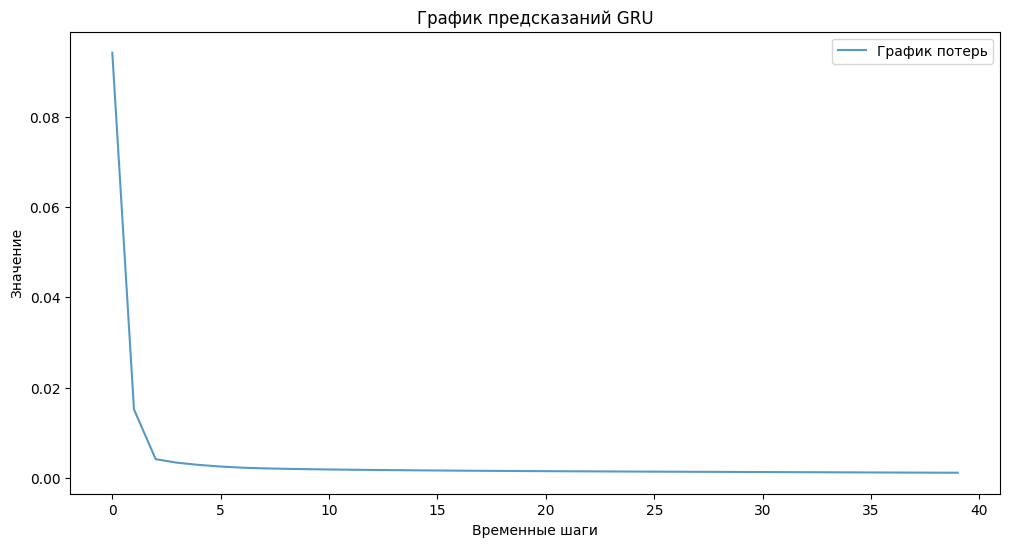

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(gru.history['loss'], label="График потерь", alpha=0.75)
plt.title("График предсказаний GRU")
plt.xlabel("Временные шаги")
plt.ylabel("Значение")
plt.legend()
plt.show()

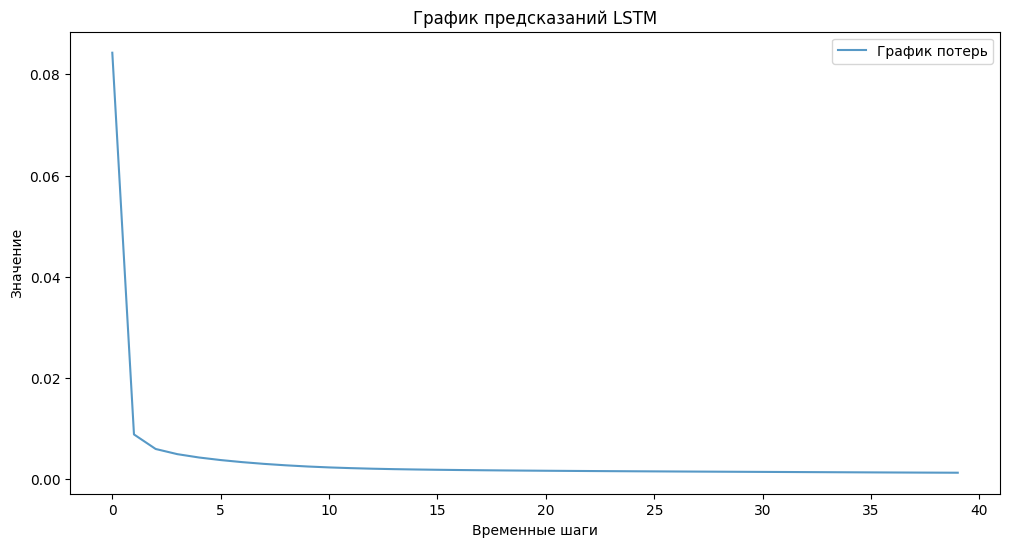

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(lstm.history['loss'], label="График потерь", alpha=0.75)
plt.title("График предсказаний LSTM")
plt.xlabel("Временные шаги")
plt.ylabel("Значение")
plt.legend()
plt.show()

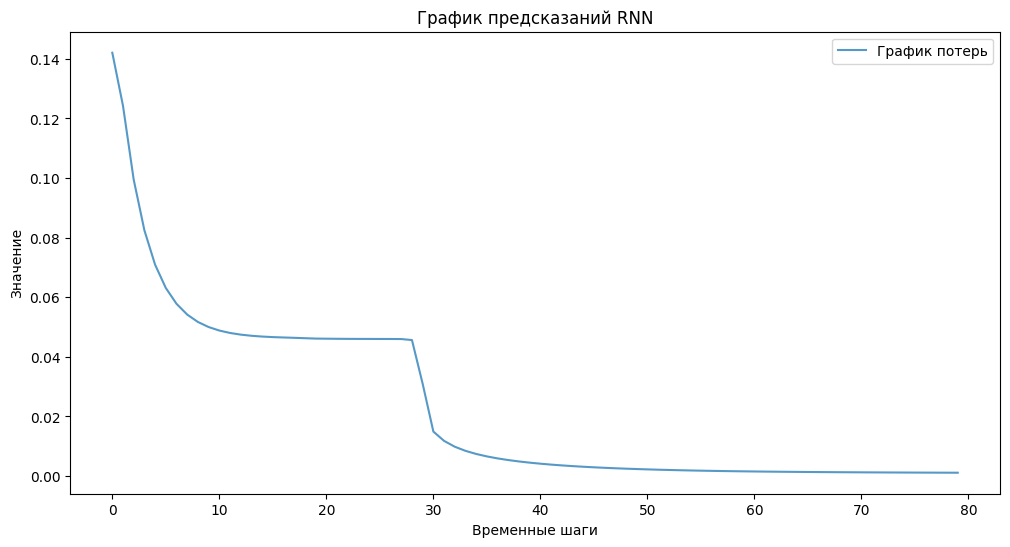

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(rnn.history['loss'], label="График потерь", alpha=0.75)
plt.title("График предсказаний RNN")
plt.xlabel("Временные шаги")
plt.ylabel("Значение")
plt.legend()
plt.show()

# Test a model

In [19]:
print(f'X_test.shape {X_test.shape}, y_test.shape {y_test.shape}')

X_test.shape (28, 8, 32, 8), y_test.shape (28, 8, 32, 1)


In [20]:
y_pred_rnn = np.empty_like(y_test)
for i in range(X_test.shape[0]):
    y_pred_rnn[i] = rnn.predict(X_test[i])

In [21]:
y_pred_lstm = np.empty_like(y_test)
for i in range(X_test.shape[0]):
    y_pred_lstm[i] = lstm.predict(X_test[i])

In [22]:
y_pred_gru = np.empty_like(y_test)
for i in range(X_test.shape[0]):
    y_pred_gru[i] = gru.predict(X_test[i])

In [23]:
y_true = y_test.transpose(0, 2, 1, 3).reshape(-1)
y_pred_rnn = y_pred_rnn.transpose(0, 2, 1, 3).reshape(-1)
y_pred_lstm = y_pred_lstm.transpose(0, 2, 1, 3).reshape(-1)
y_pred_gru = y_pred_gru.transpose(0, 2, 1, 3).reshape(-1)

In [24]:
print(y_pred_rnn.shape, y_pred_lstm.shape, y_pred_gru.shape, y_true.shape)

(7168,) (7168,) (7168,) (7168,)


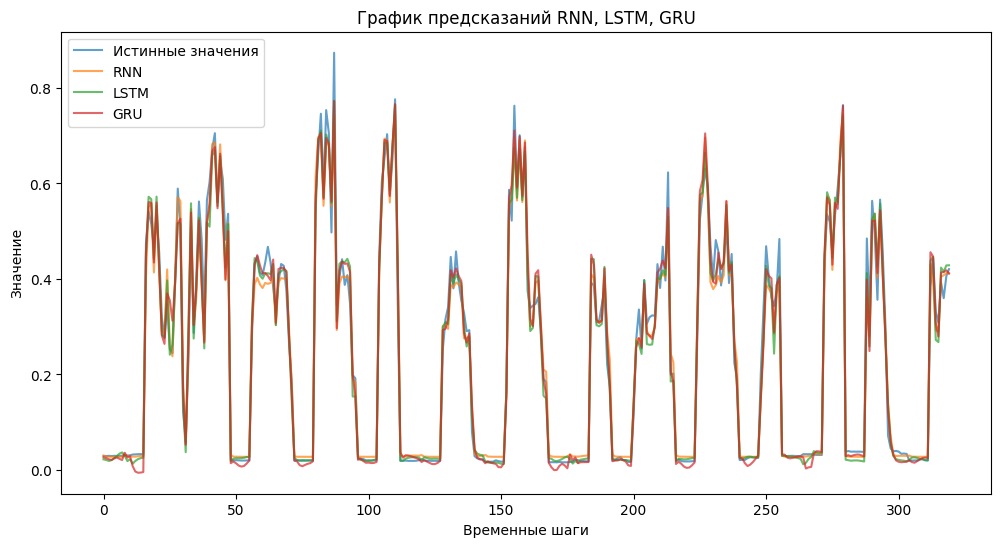

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(y_true[:320], label="Истинные значения", alpha=0.7)
plt.plot(y_pred_rnn[:320], label="RNN", alpha=0.7)
plt.plot(y_pred_lstm[:320], label="LSTM", alpha=0.7)
plt.plot(y_pred_gru[:320], label="GRU", alpha=0.7)
plt.title("График предсказаний RNN, LSTM, GRU")
plt.xlabel("Временные шаги")
plt.ylabel("Значение")
plt.legend()
plt.show()

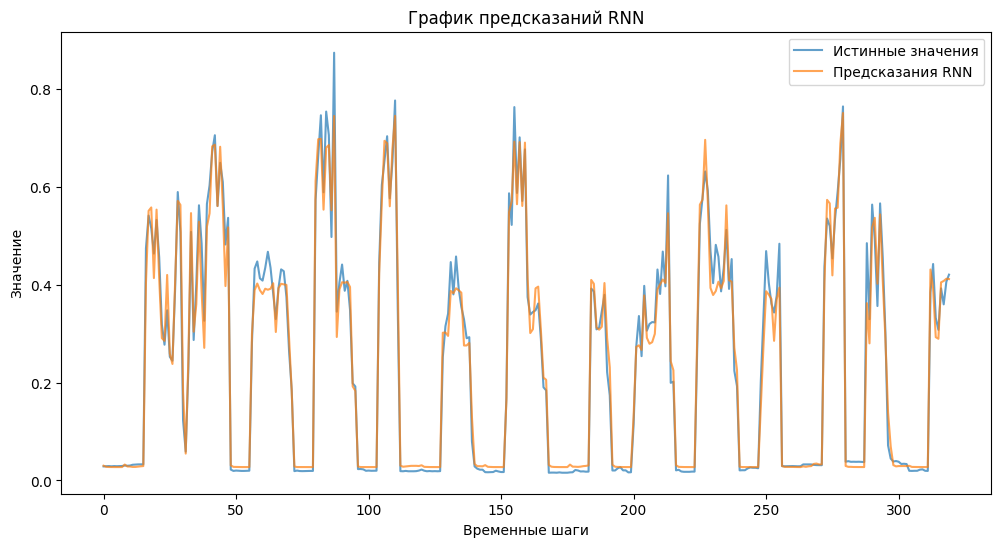

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_true[:320], label="Истинные значения", alpha=0.7)
plt.plot(y_pred_rnn[:320], label="Предсказания RNN", alpha=0.7)
plt.title("График предсказаний RNN")
plt.xlabel("Временные шаги")
plt.ylabel("Значение")
plt.legend()
plt.show()

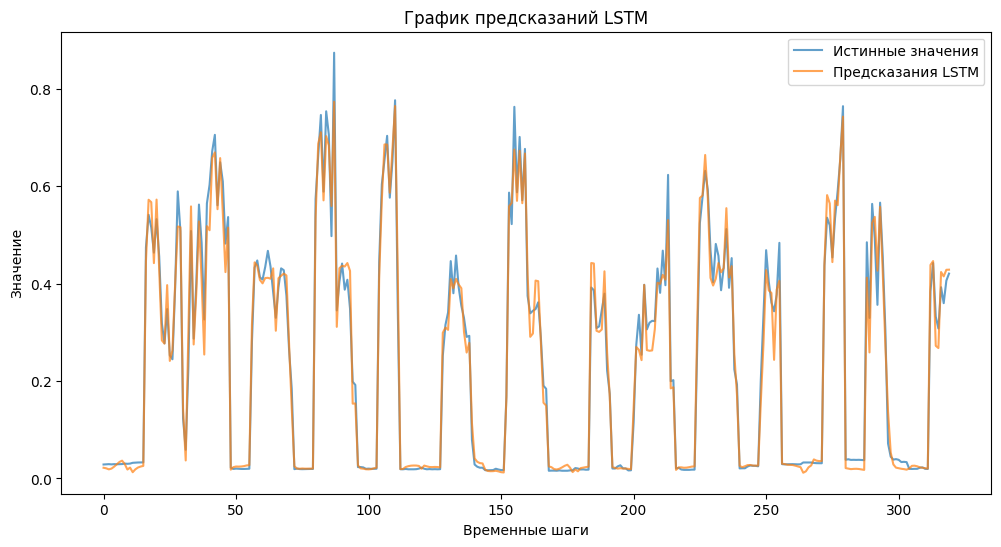

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(y_true[:320], label="Истинные значения", alpha=0.7)
plt.plot(y_pred_lstm[:320], label="Предсказания LSTM", alpha=0.7)
plt.title("График предсказаний LSTM")
plt.xlabel("Временные шаги")
plt.ylabel("Значение")
plt.legend()
plt.show()

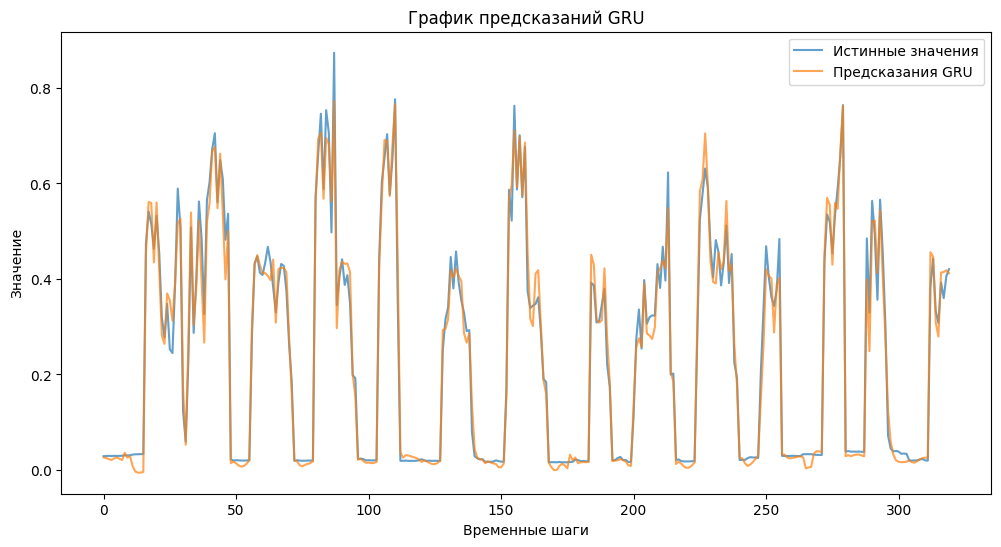

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(y_true[:320], label="Истинные значения", alpha=0.7)
plt.plot(y_pred_gru[:320], label="Предсказания GRU", alpha=0.7)
plt.title("График предсказаний GRU")
plt.xlabel("Временные шаги")
plt.ylabel("Значение")
plt.legend()
plt.show()